In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%pip install statsmodels
%pip install pmdarima
%pip install prophet
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.preprocessing import MinMaxScaler

import warnings
# Suppressing the  warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.2 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#Reading the datasets
sales_df=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Pizza_Sale.xlsx')
ingredients_df=pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Pizza_ingredients.xlsx')

In [9]:
#Details of the Sales Dataset
print(f'Shape of Sales Dataset:{sales_df.shape}\n')
print(sales_df.info(),'\n')
print(sales_df.describe(),'\n')
sales_df.head()

Shape of Sales Dataset:(48620, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pizza_id           48620 non-null  int64  
 1   order_id           48620 non-null  int64  
 2   pizza_name_id      48604 non-null  object 
 3   quantity           48620 non-null  int64  
 4   order_date         48620 non-null  object 
 5   order_time         48620 non-null  object 
 6   unit_price         48620 non-null  float64
 7   total_price        48613 non-null  float64
 8   pizza_size         48620 non-null  object 
 9   pizza_category     48597 non-null  object 
 10  pizza_ingredients  48607 non-null  object 
 11  pizza_name         48613 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 4.5+ MB
None 

           pizza_id      order_id      quantity    unit_price   total_price
count  48620.000000  48620.000000  486

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,2015-01-01 00:00:00,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,2015-01-01 00:00:00,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [10]:
#Duplicates and NaN counts for Sales data
print(sales_df.duplicated().sum())
print(sales_df.isna().sum())

0
pizza_id              0
order_id              0
pizza_name_id        16
quantity              0
order_date            0
order_time            0
unit_price            0
total_price           7
pizza_size            0
pizza_category       23
pizza_ingredients    13
pizza_name            7
dtype: int64


In [11]:
#handling Missing values for Sales dataset

sales_df['total_price']=sales_df['total_price'].fillna(sales_df['unit_price']*sales_df['quantity'])

pizza_category_mapping = sales_df[['pizza_name_id', 'pizza_category']].dropna().drop_duplicates()
pizza_category_mapping = pizza_category_mapping.set_index('pizza_name_id')['pizza_category'].to_dict()
sales_df['pizza_category'] = sales_df['pizza_category'].fillna(sales_df['pizza_name_id'].map(pizza_category_mapping))

pizza_ingredients_mapping = sales_df[['pizza_name', 'pizza_ingredients']].dropna().drop_duplicates()
pizza_ingredients_mapping = pizza_ingredients_mapping.set_index('pizza_name')['pizza_ingredients'].to_dict()
sales_df['pizza_ingredients'] = sales_df['pizza_ingredients'].fillna(sales_df['pizza_name'].map(pizza_ingredients_mapping))

pizza_name_mapping = sales_df[['pizza_ingredients', 'pizza_name']].dropna().drop_duplicates()
pizza_name_mapping = pizza_name_mapping.set_index('pizza_ingredients')['pizza_name'].to_dict()
sales_df['pizza_name'] = sales_df['pizza_name'].fillna(sales_df['pizza_ingredients'].map(pizza_name_mapping))

pizza_name_id_mapping = sales_df[['pizza_name', 'pizza_name_id']].dropna().drop_duplicates()
pizza_name_id_mapping = pizza_name_id_mapping.set_index('pizza_name')['pizza_name_id'].to_dict()
sales_df['pizza_name_id'] = sales_df['pizza_name_id'].fillna(sales_df['pizza_name'].map(pizza_name_id_mapping))

sales_df.isna().sum()

,0
pizza_id,0
order_id,0
pizza_name_id,0
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


In [12]:
#Details of Ingredients Dataset
print(f'Shape of Ingredients Dataset:{ingredients_df.shape}\n')
print(ingredients_df.info(),'\n')
print(ingredients_df.describe(),'\n')
ingredients_df.head()

Shape of Ingredients Dataset:(518, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   pizza_name_id       518 non-null    object 
 1   pizza_name          518 non-null    object 
 2   pizza_ingredients   518 non-null    object 
 3   Items_Qty_In_Grams  514 non-null    float64
dtypes: float64(1), object(3)
memory usage: 16.3+ KB
None 

       Items_Qty_In_Grams
count          514.000000
mean            30.564202
std             30.351623
min              5.000000
25%             10.000000
50%             20.000000
75%             40.000000
max            200.000000 



,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0


In [13]:
#Duplicates and NaN counts for Ingredients Data
print(ingredients_df.duplicated().sum())
print(ingredients_df.isna().sum())

0
pizza_name_id         0
pizza_name            0
pizza_ingredients     0
Items_Qty_In_Grams    4
dtype: int64


In [14]:
#Handling NaN values from Ingredients Dataset
ingredients_df[ingredients_df['Items_Qty_In_Grams'].isna()]

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams
24,brie_carre_s,The Brie Carre Pizza,Caramelized Onions,NaN
149,hawaiian_l,The Hawaiian Pizza,Sliced Ham,NaN
152,hawaiian_m,The Hawaiian Pizza,Sliced Ham,NaN
155,hawaiian_s,The Hawaiian Pizza,Sliced Ham,NaN


In [15]:
mean_qty = ingredients_df.groupby('pizza_name_id')['Items_Qty_In_Grams'].mean()
ingredients_df['Items_Qty_In_Grams'] = ingredients_df['Items_Qty_In_Grams'].fillna(ingredients_df['pizza_name_id'].map(mean_qty))
ingredients_df.isna().sum()

,0
pizza_name_id,0
pizza_name,0
pizza_ingredients,0
Items_Qty_In_Grams,0


In [16]:
#Merging the two datasets

merged_df = pd.merge(sales_df,ingredients_df, on='pizza_name_id', how='inner')
print(f'Shaped of Merged dataset:\n{merged_df.shape}')
print(merged_df.info())
print(merged_df.describe())
print(merged_df.duplicated().sum())
print(merged_df.isna().sum())
merged_df.head()

Shaped of Merged dataset:
(267576, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267576 entries, 0 to 267575
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   pizza_id             267576 non-null  int64  
 1   order_id             267576 non-null  int64  
 2   pizza_name_id        267576 non-null  object 
 3   quantity             267576 non-null  int64  
 4   order_date           267576 non-null  object 
 5   order_time           267576 non-null  object 
 6   unit_price           267576 non-null  float64
 7   total_price          267576 non-null  float64
 8   pizza_size           267576 non-null  object 
 9   pizza_category       267576 non-null  object 
 10  pizza_ingredients_x  267576 non-null  object 
 11  pizza_name_x         267576 non-null  object 
 12  pizza_name_y         267576 non-null  object 
 13  pizza_ingredients_y  267576 non-null  object 
 14  Items_Qty_In_Grams   267576 n

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients_x,pizza_name_x,pizza_name_y,pizza_ingredients_y,Items_Qty_In_Grams
0,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Sliced Ham,25.0
1,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Pineapple,30.0
2,1,1,hawaiian_m,1,2015-01-01 00:00:00,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza,The Hawaiian Pizza,Mozzarella Cheese,20.0
3,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Pepperoni,40.0
4,2,2,classic_dlx_m,1,2015-01-01 00:00:00,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza,The Classic Deluxe Pizza,Mushrooms,40.0


In [17]:
merged_df.drop(columns=['pizza_name_y', 'pizza_ingredients_y'], inplace=True)
merged_df.rename(columns={
    'pizza_name_x': 'pizza_name',
    'pizza_ingredients_x': 'pizza_ingredients'
}, inplace=True)

In [18]:
merged_df.duplicated().sum()

80204

In [19]:
merged_df=merged_df.drop_duplicates()
merged_df.duplicated().sum()
print(merged_df.info())
print()
print(merged_df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 187372 entries, 0 to 267573
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   pizza_id            187372 non-null  int64  
 1   order_id            187372 non-null  int64  
 2   pizza_name_id       187372 non-null  object 
 3   quantity            187372 non-null  int64  
 4   order_date          187372 non-null  object 
 5   order_time          187372 non-null  object 
 6   unit_price          187372 non-null  float64
 7   total_price         187372 non-null  float64
 8   pizza_size          187372 non-null  object 
 9   pizza_category      187372 non-null  object 
 10  pizza_ingredients   187372 non-null  object 
 11  pizza_name          187372 non-null  object 
 12  Items_Qty_In_Grams  187372 non-null  float64
dtypes: float64(3), int64(3), object(7)
memory usage: 20.0+ MB
None

            pizza_id       order_id       quantity     unit_price  \
count 

In [20]:
pip install holidays

In [21]:
#Handling the dates and applying the holidays and weekend offers

import holidays
def extract_date(date):
    formats = ['%d-%m-%Y', '%d/%m/%Y', '%m/%d/%Y']
    for fmt in formats:
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.NaT

merged_df['order_date'] = merged_df['order_date'].apply(extract_date)

merged_df['day_of_week'] = merged_df['order_date'].dt.dayofweek # day_name()
merged_df['month'] = merged_df['order_date'].dt.month # month_name()
merged_df['week'] = merged_df['order_date'].dt.isocalendar().week
merged_df['year'] = merged_df['order_date'].dt.year

holiday_list=holidays.US()
merged_df['holiday'] = merged_df['order_date'].apply(lambda x: 1 if x in holiday_list else 0)
merged_df['offer'] = merged_df['order_date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)


In [22]:
print(merged_df.shape)
print(merged_df.info())
print(merged_df.describe())
merged_df.isna().sum()

(187372, 19)
<class 'pandas.core.frame.DataFrame'>
Index: 187372 entries, 0 to 267573
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   pizza_id            187372 non-null  int64         
 1   order_id            187372 non-null  int64         
 2   pizza_name_id       187372 non-null  object        
 3   quantity            187372 non-null  int64         
 4   order_date          187372 non-null  datetime64[ns]
 5   order_time          187372 non-null  object        
 6   unit_price          187372 non-null  float64       
 7   total_price         187372 non-null  float64       
 8   pizza_size          187372 non-null  object        
 9   pizza_category      187372 non-null  object        
 10  pizza_ingredients   187372 non-null  object        
 11  pizza_name          187372 non-null  object        
 12  Items_Qty_In_Grams  187372 non-null  float64       
 13  day_of_week         1

,0
pizza_id,0
order_id,0
pizza_name_id,0
quantity,0
order_date,0
order_time,0
unit_price,0
total_price,0
pizza_size,0
pizza_category,0


In [23]:
#Sales by order date
daily_sales=merged_df.groupby('order_date')['quantity'].sum().reset_index()
daily_sales

,order_date,quantity
0,2015-01-01,620
1,2015-01-02,741
2,2015-01-03,379
3,2015-01-04,508
4,2015-01-05,594
...,...,...
353,2015-12-27,347
354,2015-12-28,381
355,2015-12-29,302
356,2015-12-30,327


In [24]:
# A week pizza sales
week_7_sales = merged_df[merged_df['week'] == 7]
grouped_sales = week_7_sales.groupby('pizza_name')['quantity'].sum().reset_index()
print(f"Pizzas sold in week 7:")
for _, row in grouped_sales.iterrows():
    print(f"{row['pizza_name']}: {row['quantity']} pizzas")
total_quantity_sold = week_7_sales['quantity'].sum()
print(f"\nTotal units of pizza sold in week 7: {total_quantity_sold} pizzas")

Pizzas sold in week 7:
The Barbecue Chicken Pizza: 299 pizzas
The Big Meat Pizza: 96 pizzas
The Brie Carre Pizza: 32 pizzas
The Calabrese Pizza: 88 pizzas
The California Chicken Pizza: 226 pizzas
The Chicken Alfredo Pizza: 133 pizzas
The Chicken Pesto Pizza: 64 pizzas
The Classic Deluxe Pizza: 132 pizzas
The Five Cheese Pizza: 58 pizzas
The Four Cheese Pizza: 181 pizzas
The Greek Pizza: 141 pizzas
The Green Garden Pizza: 78 pizzas
The Hawaiian Pizza: 105 pizzas
The Italian Capocollo Pizza: 132 pizzas
The Italian Supreme Pizza: 148 pizzas
The Italian Vegetables Pizza: 59 pizzas
The Mediterranean Pizza: 73 pizzas
The Mexicana Pizza: 140 pizzas
The Napolitana Pizza: 68 pizzas
The Pepper Salami Pizza: 80 pizzas
The Pepperoni Pizza: 98 pizzas
The Pepperoni, Mushroom, and Peppers Pizza: 33 pizzas
The Prosciutto and Arugula Pizza: 71 pizzas
The Sicilian Pizza: 176 pizzas
The Soppressata Pizza: 68 pizzas
The Southwest Chicken Pizza: 170 pizzas
The Spicy Italian Pizza: 161 pizzas
The Spinach Pe

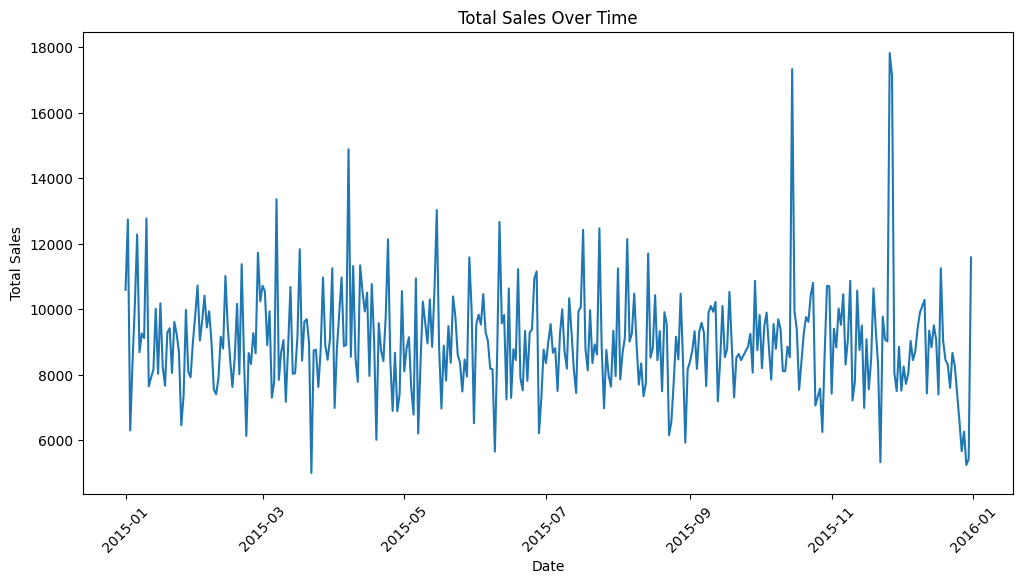

In [25]:
# Data Visualization
# Sales over time
sales_over_time = merged_df.groupby('order_date')['total_price'].sum().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=sales_over_time, x='order_date', y='total_price')
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

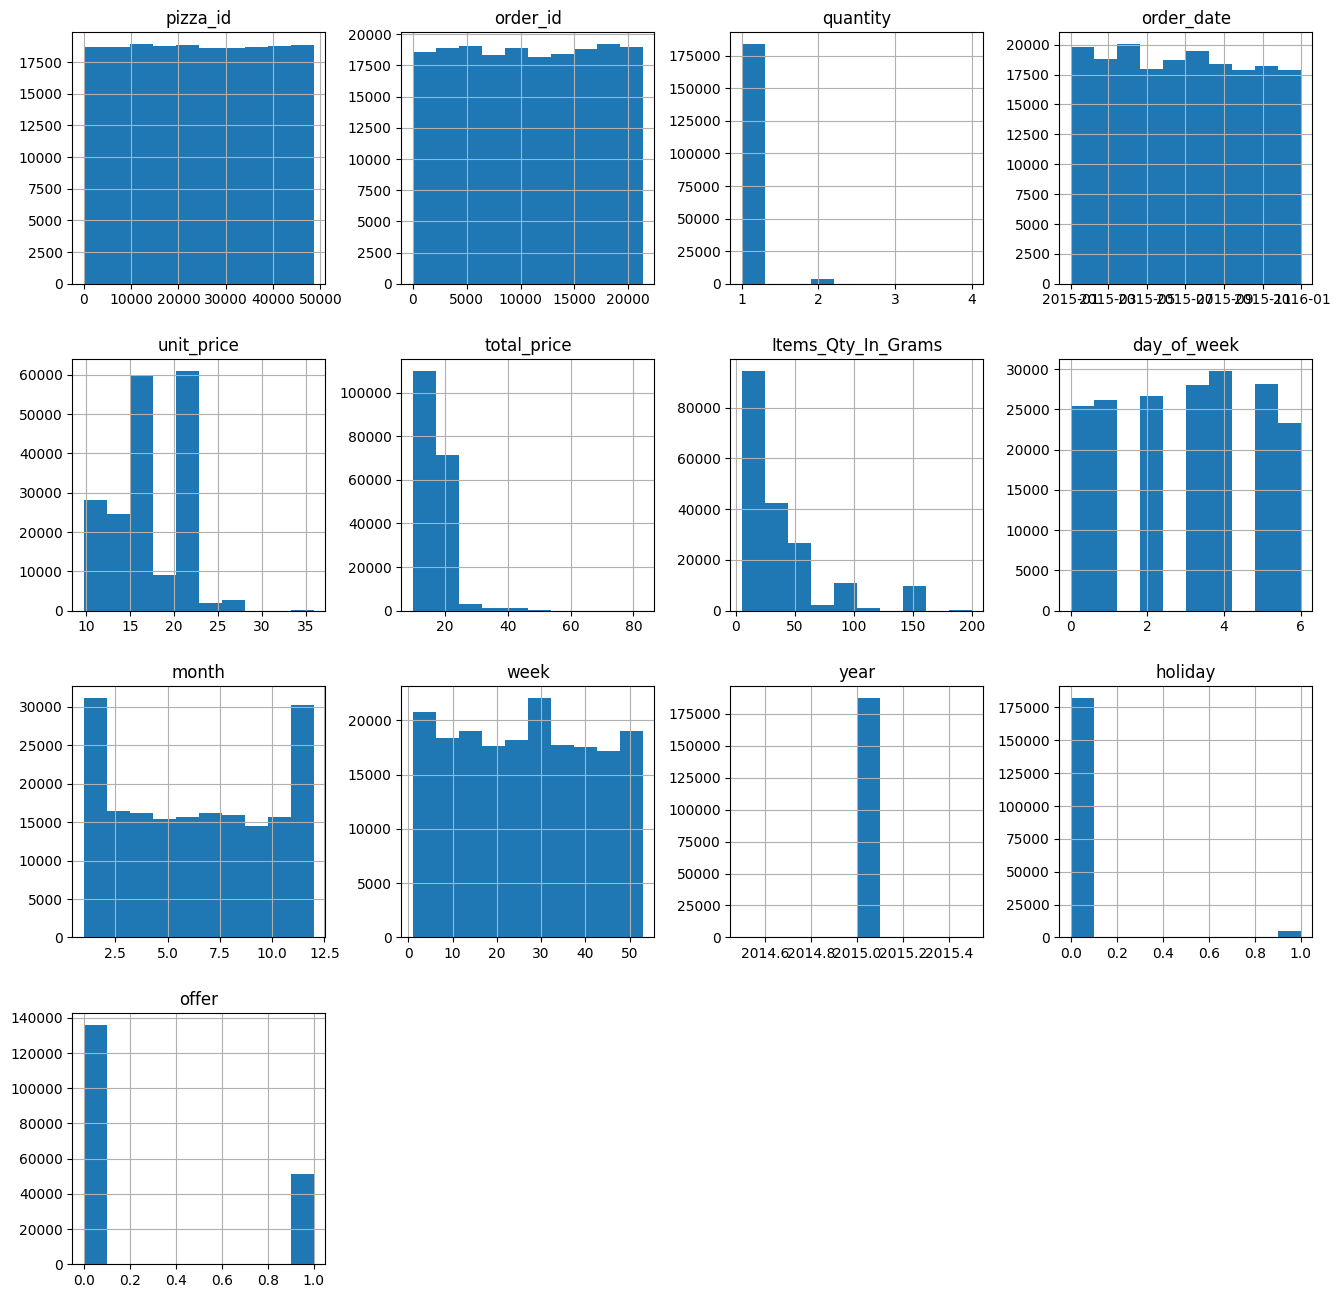

In [26]:
merged_df.hist(figsize=(16,16))
plt.show()

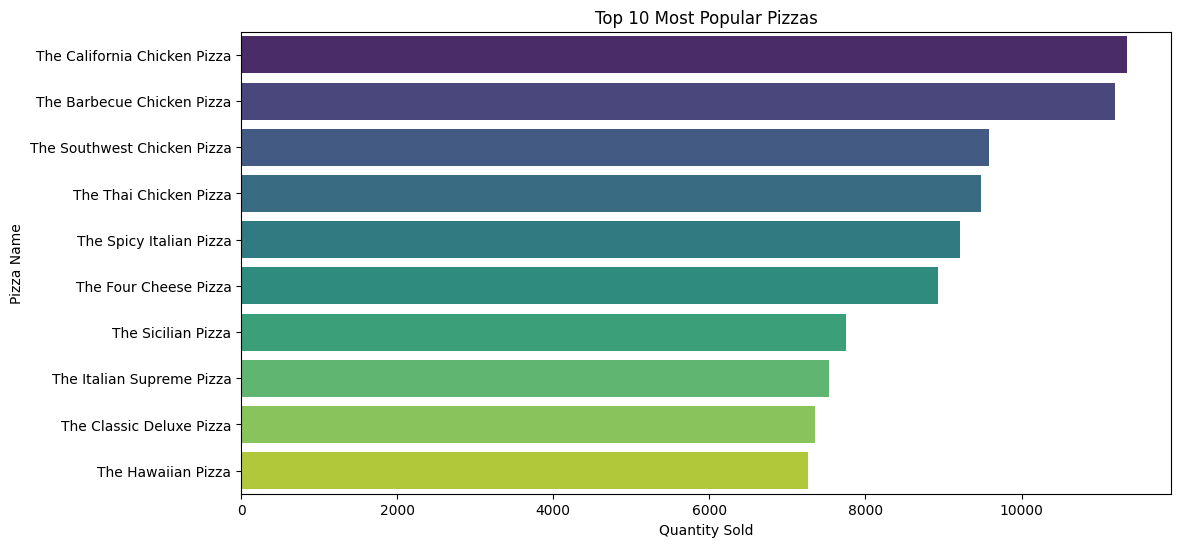

In [27]:
#Top Selling Pizzas
pizza_sales = merged_df.groupby('pizza_name')['quantity'].sum().reset_index()

# Sorting by quantity sold
pizza_sales = pizza_sales.sort_values(by='quantity', ascending=False)

# Ploting top 10 most popular pizzas
plt.figure(figsize=(12,6))
sns.barplot(data=pizza_sales.head(10), x='quantity', y='pizza_name', palette='viridis')
plt.title('Top 10 Most Popular Pizzas')
plt.xlabel('Quantity Sold')
plt.ylabel('Pizza Name')
plt.show()

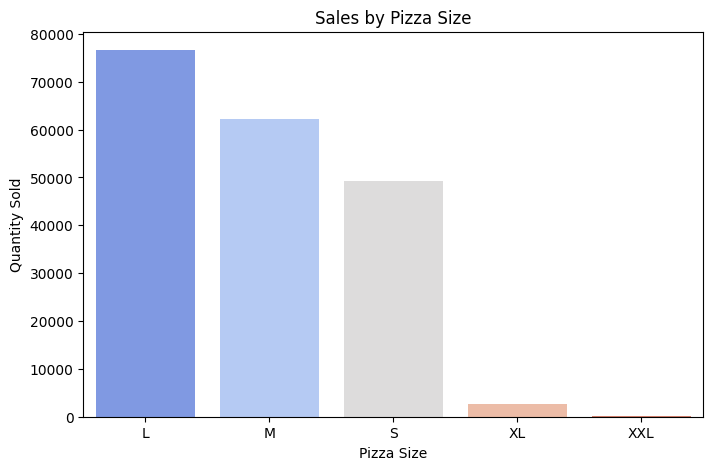

In [28]:
#Sales by Pizza Size
size_sales = merged_df.groupby('pizza_size')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=size_sales, x='pizza_size', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Size')
plt.xlabel('Pizza Size')
plt.ylabel('Quantity Sold')
plt.show()

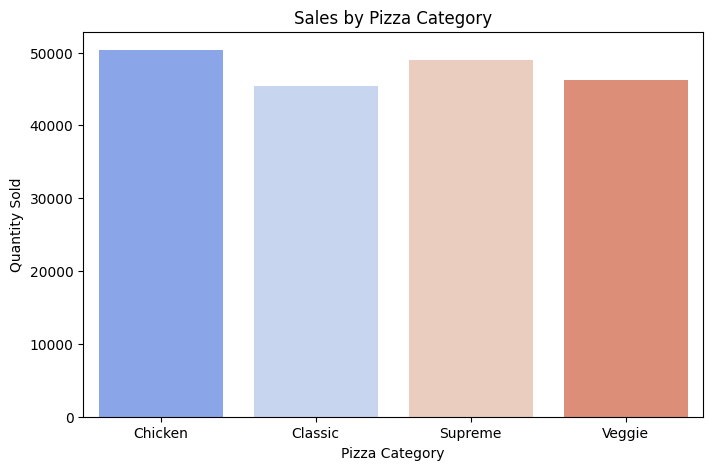

In [29]:
#Sales by Pizza Category
category_sales = merged_df.groupby('pizza_category')['quantity'].sum().reset_index()

plt.figure(figsize=(8,5))
sns.barplot(data=category_sales, x='pizza_category', y='quantity', palette='coolwarm')
plt.title('Sales by Pizza Category')
plt.xlabel('Pizza Category')
plt.ylabel('Quantity Sold')
plt.show()

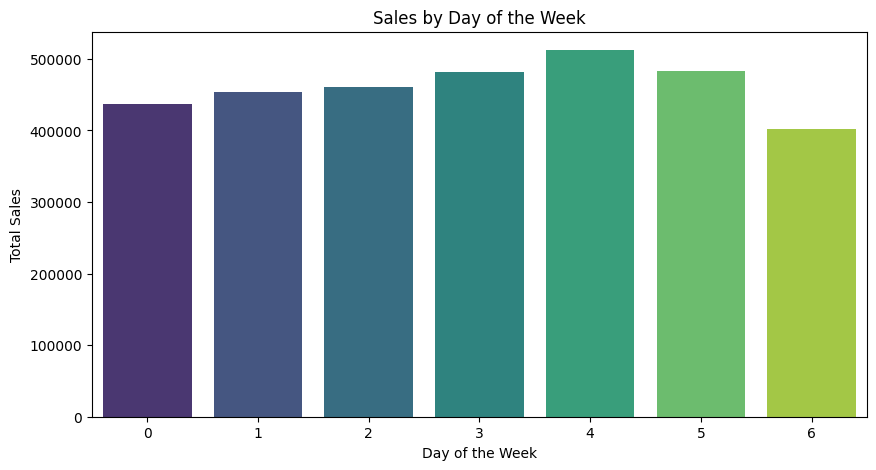

In [30]:
#Sales by Days
sales_by_day = merged_df.groupby('day_of_week')['total_price'].sum().reset_index()

# Order days of the week
#days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
days_order = [0, 1, 2, 3, 4, 5, 6]
sales_by_day['day_of_week'] = pd.Categorical(sales_by_day['day_of_week'], categories=days_order, ordered=True)

# Plot sales by day of the week
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_day, x='day_of_week', y='total_price', palette='viridis')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.show()

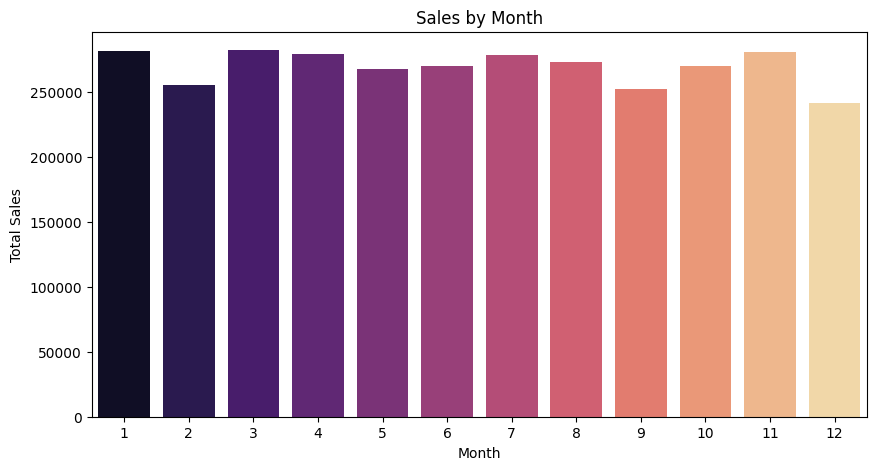

In [31]:
#sales by Month
sales_by_month = merged_df.groupby('month')['total_price'].sum().reset_index()

# Plot sales by month
plt.figure(figsize=(10,5))
sns.barplot(data=sales_by_month, x='month', y='total_price', palette='magma')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

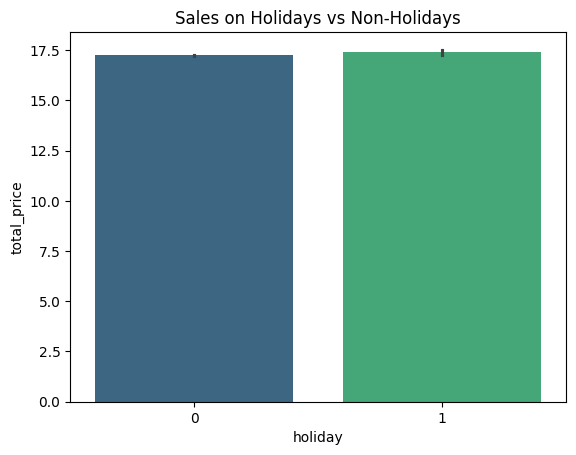

In [32]:
#Sales during holidays
sns.barplot(x='holiday', y='total_price', data=merged_df, palette='viridis')
plt.title('Sales on Holidays vs Non-Holidays')
plt.show()

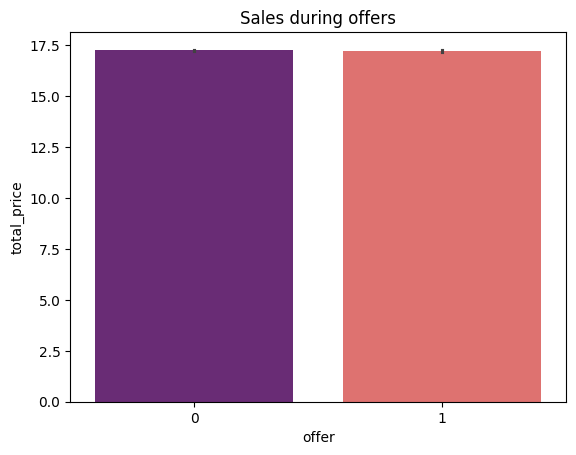

In [33]:
#Sales during Offers
sns.barplot(x='offer', y='total_price', data=merged_df, palette='magma')
plt.title('Sales during offers')
plt.show()


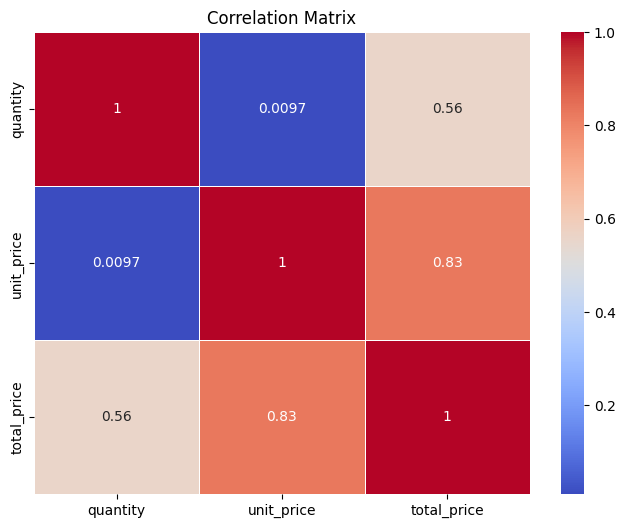

In [34]:
# Correlation matrix
corr_matrix = merged_df[['quantity', 'unit_price', 'total_price']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

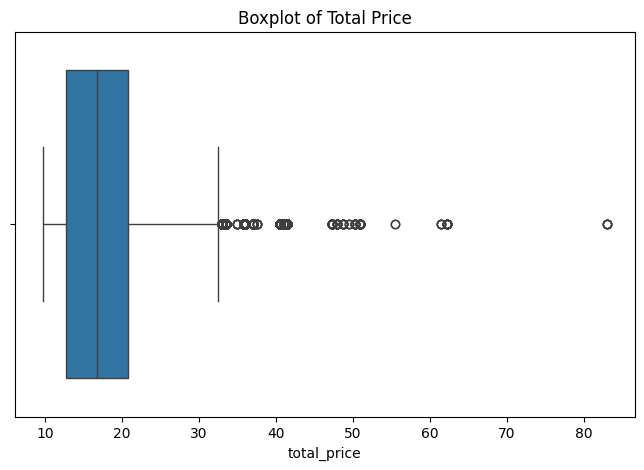

In [35]:
# Boxplot for total_price
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df, x='total_price')
plt.title('Boxplot of Total Price')
plt.show()

Best ARIMA Model MAPE: 0.1976, Best Parameters: (3, 1, 5)
Predictions:
order_date
2015-10-19    3453.621947
2015-10-26    3839.852295
2015-11-02    3634.093874
2015-11-09    3649.615095
2015-11-16    3552.311612
2015-11-23    3876.134061
2015-11-30    3532.251213
2015-12-07    3659.119487
2015-12-14    3649.664429
2015-12-21    3822.957176
2015-12-28    3458.981438
Name: predicted_mean, dtype: float64


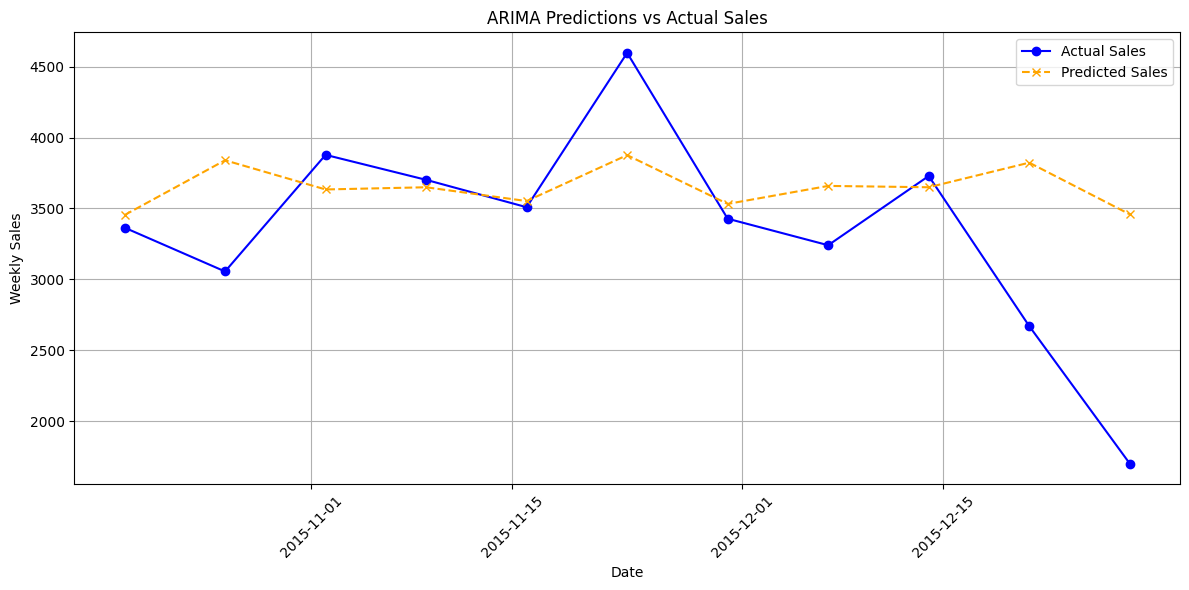

In [36]:
#ARIMA Model
import itertools

# Pizza sales by week
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_df)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# ARIMA Model Tuneing
def tune_arima_model(train, test, p_values, d_values, q_values):
    best_score, best_params, best_predictions = float("inf"), None, None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            predictions = model.forecast(steps=len(test))
            arima_mape = mape(test, predictions)
            if arima_mape < best_score:
                best_score, best_params, best_predictions = arima_mape, (p, d, q), predictions
        except:
            continue

    print(f"Best ARIMA Model MAPE: {best_score:.4f}, Best Parameters: {best_params}")
    return best_predictions, best_score, best_params

p_values, d_values, q_values = range(0, 6), range(0, 2), range(0, 6)
arima_predictions, arima_mape_score, best_params = tune_arima_model(train, test, p_values, d_values, q_values)

# Formating the predictions for display
arima_predictions = pd.Series(arima_predictions, index=test.index)

print("Predictions:")
print(arima_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(arima_predictions.index, arima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('ARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Best SARIMA Model MAPE: 0.2327
Predictions:
order_date
2015-10-19    3639.064892
2015-10-26    3962.060814
2015-11-02    3803.567945
2015-11-09    3536.255627
2015-11-16    3700.833916
2015-11-23    3810.493783
2015-11-30    3827.372004
2015-12-07    3746.217240
2015-12-14    4015.172830
2015-12-21    3866.686546
2015-12-28    3566.403136
Name: predicted_mean, dtype: float64


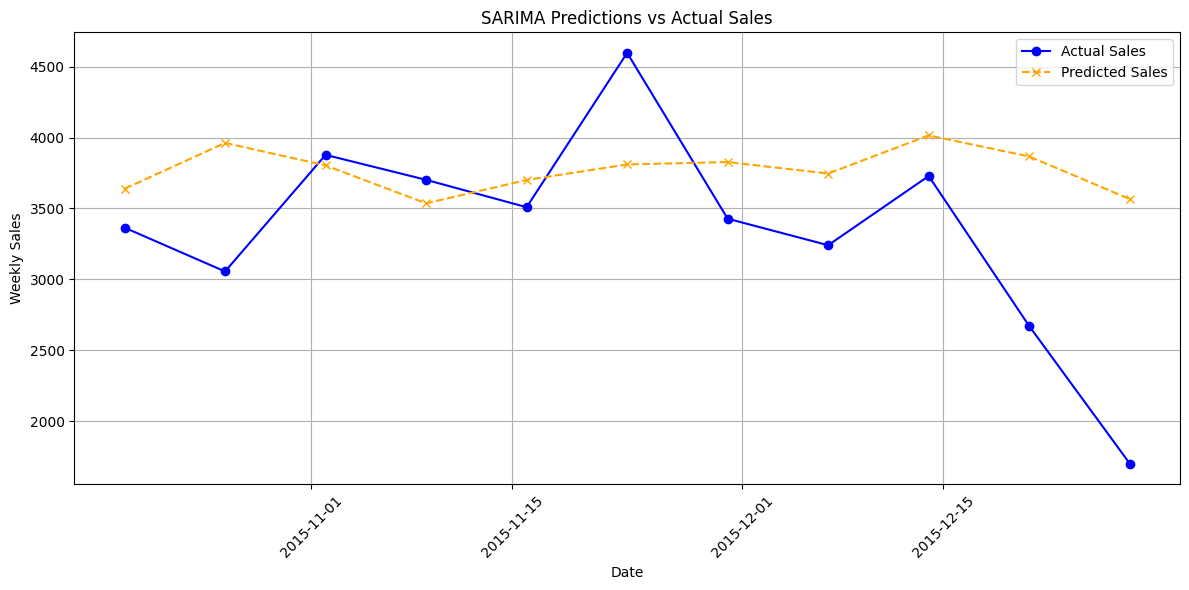

In [37]:
#SARIMA Model
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_df)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best SARIMA Model Training and Output
def best_sarima_model(train, test):
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
    predictions = model.forecast(steps=len(test))
    sarima_mape = mape(test, predictions)

    print(f"Best SARIMA Model MAPE: {sarima_mape:.4f}")
    return predictions, sarima_mape

# Train and evaluate the SARIMA model
sarima_predictions, sarima_mape_score = best_sarima_model(train, test)

# Formating the predictions for display
sarima_predictions = pd.Series(sarima_predictions, index=test.index)

print("Predictions:")
print(sarima_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test.values, label='Actual Sales', color='blue', marker='o')
plt.plot(sarima_predictions.index, sarima_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('SARIMA Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmzx20wqv/xfjuwhgk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmzx20wqv/uicngig0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50431', 'data', 'file=/tmp/tmpmzx20wqv/xfjuwhgk.json', 'init=/tmp/tmpmzx20wqv/uicngig0.json', 'output', 'file=/tmp/tmpmzx20wqv/prophet_modelguwkyoix/prophet_model-20241207143608.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:36:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:36:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Best Prophet Model MAPE: 0.2163
Predictions:
ds
2015-10-19    3684.955697
2015-10-26    3685.691317
2015-11-02    3686.426937
2015-11-09    3687.162557
2015-11-16    3687.898177
2015-11-23    3688.633796
2015-11-30    3689.369416
2015-12-07    3690.105036
2015-12-14    3690.840656
2015-12-21    3691.576276
2015-12-28    3692.311896
dtype: float64


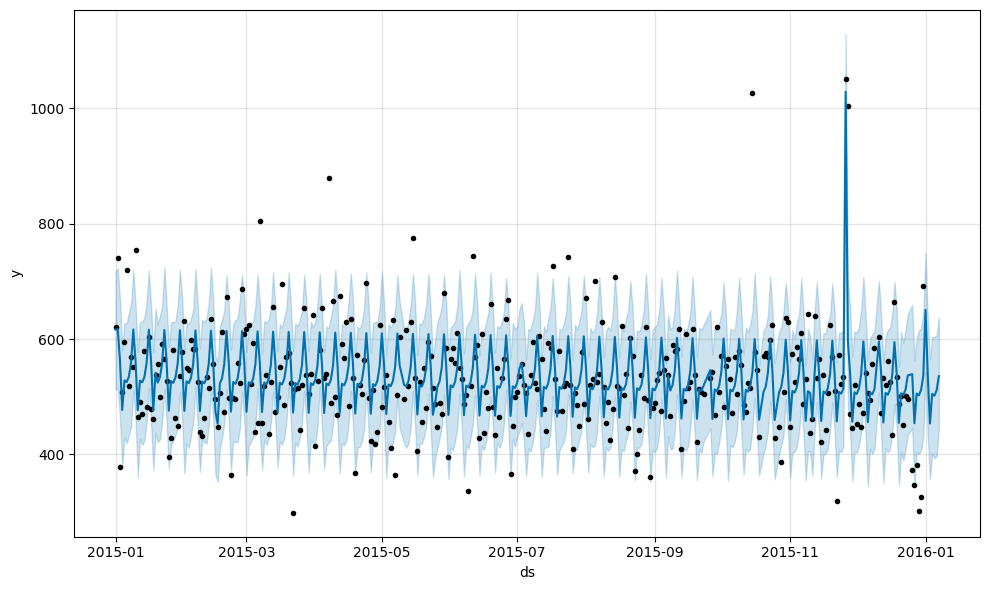

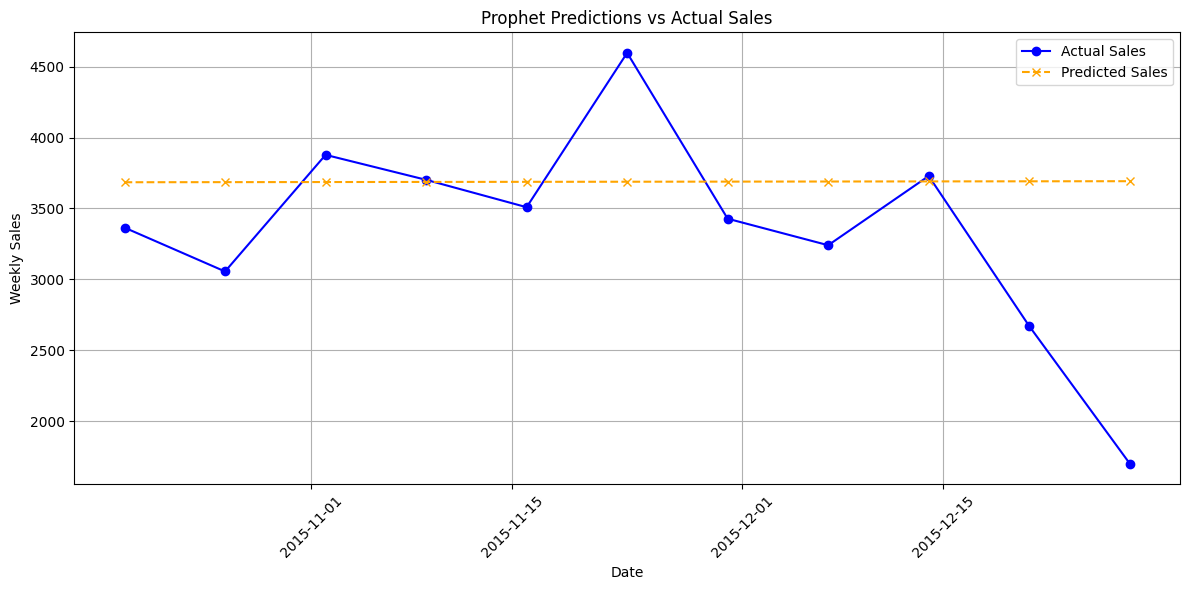

In [38]:
# Prophet model
daily_sales['order_date'] = pd.to_datetime(daily_sales['order_date'])

# renameing the columns to 'ds' for dates and 'y' for the target values
prophet_data = daily_sales.rename(columns={'order_date': 'ds', 'quantity': 'y'})

# Model fiting
prophet_model = Prophet()
prophet_model.add_country_holidays(country_name='US')
prophet_model.fit(prophet_data)

# Future forecast for the next 7 days
future_dates = prophet_model.make_future_dataframe(periods=7)
prophet_forecast = prophet_model.predict(future_dates)

# Displaying the forecast
fig = prophet_model.plot(prophet_forecast)

def prepare_weekly_sales_for_prophet(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    weekly_sales.columns = ['ds', 'y']  # Prophet requires columns 'ds' for date and 'y' for the target variable
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales_for_prophet(merged_df)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# MAPE
def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual))

# Best Prophet Model Training and Output
def best_prophet_model(train, test):
    model = Prophet()
    model.fit(train)

    future = model.make_future_dataframe(periods=len(test), freq='W')
    forecast = model.predict(future)
    predictions = forecast['yhat'][-len(test):].values
    prophet_mape = mape(test['y'].values, predictions)

    print(f"Best Prophet Model MAPE: {prophet_mape:.4f}")
    return predictions, prophet_mape

# Train and evaluate the Prophet model
prophet_predictions, prophet_mape_score = best_prophet_model(train, test)

# Formating the predictions for display
prophet_predictions = pd.Series(prophet_predictions, index=test['ds'])

print("Predictions:")
print(prophet_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], test['y'], label='Actual Sales', color='blue', marker='o')
plt.plot(prophet_predictions.index, prophet_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Prophet Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

Best Regression Model MAPE: 0.1906
Predictions:
order_date
2015-10-19    3593.582950
2015-10-26    3540.495581
2015-11-02    3700.838915
2015-11-09    3647.751546
2015-11-16    3594.664177
2015-11-23    3541.576808
2015-11-30    3488.489439
2015-12-07    3648.832773
2015-12-14    3595.745404
2015-12-21    3542.658035
2015-12-28    3489.570666
dtype: float64


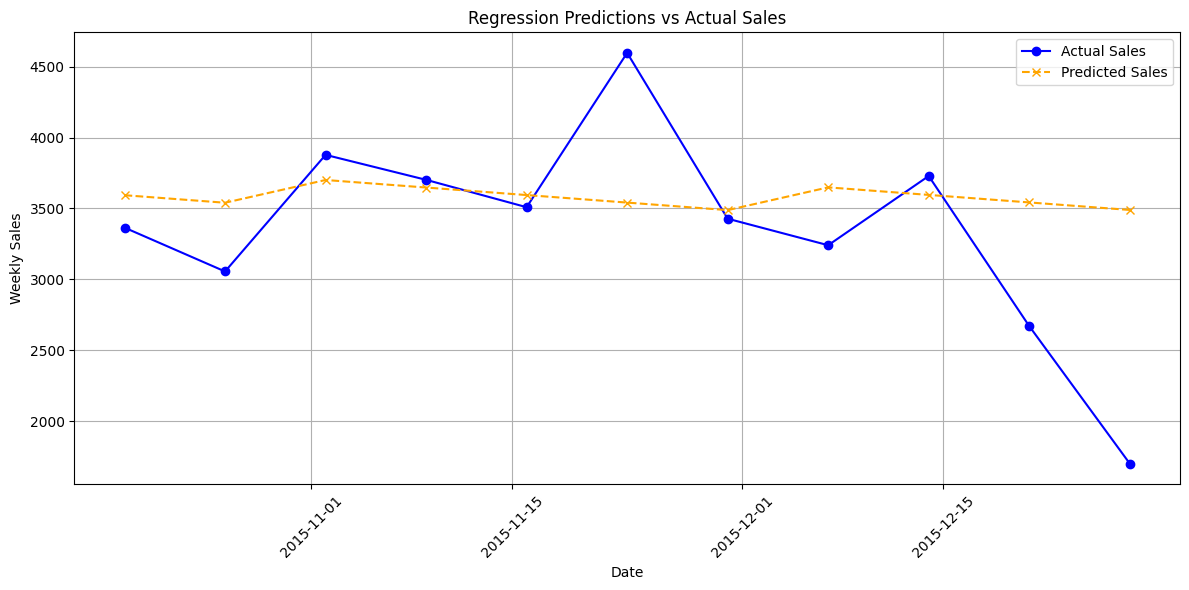

In [45]:
# Regression Model
def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

# Feature Engineering for Regression
def create_regression_features(df):
    df['week_of_year'] = df['order_date'].dt.isocalendar().week
    df['day_of_week'] = df['order_date'].dt.dayofweek
    df['month'] = df['order_date'].dt.month
    df['year'] = df['order_date'].dt.year
    return df

pizza_sales_weekly = prepare_weekly_sales(merged_df)
pizza_sales_weekly = create_regression_features(pizza_sales_weekly)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Prepareing data for Regression
X_train = train[['week_of_year', 'day_of_week', 'month', 'year']]
y_train = train['quantity']
X_test = test[['week_of_year', 'day_of_week', 'month', 'year']]
y_test = test['quantity']

# Best Regression Model Training and Output
def best_regression_model(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    regression_mape = mape(y_test, predictions)

    print(f"Best Regression Model MAPE: {regression_mape:.4f}")
    return model,predictions, regression_mape

# Train and evaluate the Regression model
best_model, regression_predictions, regression_mape_score = best_regression_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
regression_predictions = pd.Series(regression_predictions, index=test['order_date'])

print("Predictions:")
print(regression_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'], y_test, label='Actual Sales', color='blue', marker='o')
plt.plot(regression_predictions.index, regression_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('Regression Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [40]:
%pip install tensorflow

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
Best LSTM Model MAPE: 0.2493
Predictions:
order_date
2015-11-09    3563.625732
2015-11-16    3634.437500
2015-11-23    3773.023926
2015-11-30    3921.716553
2015-12-07    3874.293701
2015-12-14    3859.300049
2015-12-21    3589.749756
2015-12-28    3444.254395
dtype: float32


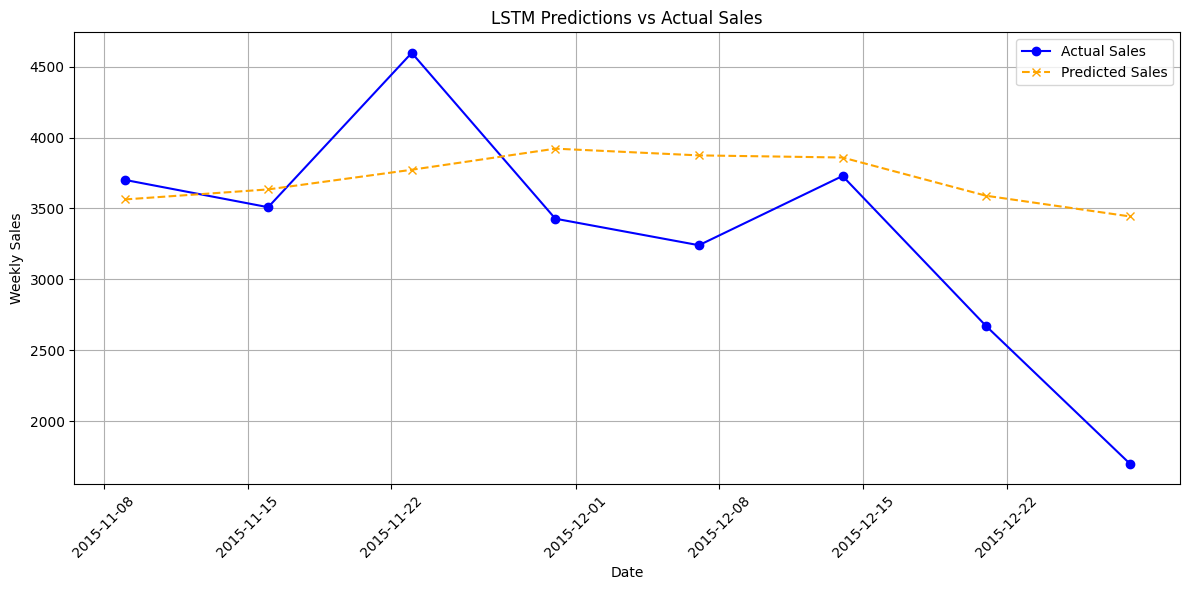

In [42]:
# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

def prepare_weekly_sales(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    weekly_sales = df.groupby(df['order_date'].dt.to_period('W').apply(lambda r: r.start_time))['quantity'].sum().reset_index()
    return weekly_sales

pizza_sales_weekly = prepare_weekly_sales(merged_df)

# train test split
train_size = int(0.8 * len(pizza_sales_weekly))
train, test = pizza_sales_weekly[:train_size], pizza_sales_weekly[train_size:]

# Normalizeing the data for LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['quantity']])
test_scaled = scaler.transform(test[['quantity']])

# Prepareing data for LSTM
def create_lstm_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3
X_train, y_train = create_lstm_dataset(train_scaled, time_steps)
X_test, y_test = create_lstm_dataset(test_scaled, time_steps)

# Reshapeing X for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Training LSTM Model
def best_lstm_model(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    lstm_mape = mape(y_test_rescaled, predictions)

    print(f"Best LSTM Model MAPE: {lstm_mape:.4f}")
    return predictions, lstm_mape, y_test_rescaled

# Train and evaluate the LSTM model
lstm_predictions, lstm_mape_score, y_test_rescaled = best_lstm_model(X_train, y_train, X_test, y_test)

# Formating the predictions for display
lstm_predictions = pd.Series(lstm_predictions.flatten(), index=test['order_date'][time_steps:])

print("Predictions:")
print(lstm_predictions)

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test['order_date'][time_steps:], y_test_rescaled, label='Actual Sales', color='blue', marker='o')
plt.plot(lstm_predictions.index, lstm_predictions, label='Predicted Sales', color='orange', linestyle='--', marker='x')
plt.title('LSTM Predictions vs Actual Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [82]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np

# Function to prepare weekly sales data by pizza
def prepare_weekly_sales_by_pizza(df):
    df['order_date'] = pd.to_datetime(df['order_date'])
    df['week'] = df['order_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_sales_by_pizza = df.groupby(['week', 'pizza_name_id'])['quantity'].sum().reset_index()
    weekly_sales_by_pizza.set_index('week', inplace=True)
    return weekly_sales_by_pizza

pizza_sales_weekly_by_pizza = prepare_weekly_sales_by_pizza(merged_df)

# Function to forecast sales for each pizza type using Linear Regression
def forecast_sales_per_pizza_type_linear_regression(pizza_type, train, periods=1):
    # Prepare the data for Linear Regression
    train = train.reset_index()
    train['week_ordinal'] = train['week'].apply(lambda x: x.toordinal())

    X = train[['week_ordinal']]
    y = train['quantity']

    # Train the Linear Regression model
    model = LinearRegression()
    model.fit(X, y)

    # Forecasting for the next week
    last_week_ordinal = train['week_ordinal'].max()
    future_weeks = np.array([last_week_ordinal + i for i in range(1, periods + 1)]).reshape(-1, 1)
    forecast = model.predict(future_weeks)

    return pizza_type, forecast.tolist()

# Forecasting next week's sales for each pizza type using Linear Regression
def forecast_next_week_sales_by_pizza_type_linear_regression(pizza_sales_weekly_by_pizza, periods=1):
    pizza_type_forecasts = {}

    # Total sales per pizza type
    total_units_sold = pizza_sales_weekly_by_pizza.groupby('pizza_name_id')['quantity'].sum()

    # Last week in the dataset
    last_week = pizza_sales_weekly_by_pizza.index.max()
    next_week_start = last_week + pd.Timedelta(weeks=0.6)
    next_week_end = next_week_start + pd.Timedelta(days=6)

    # Looping through each pizza type
    for pizza_type in pizza_sales_weekly_by_pizza['pizza_name_id'].unique():
        pizza_type_data = pizza_sales_weekly_by_pizza[pizza_sales_weekly_by_pizza['pizza_name_id'] == pizza_type]

        # Train-test split
        train_size = int(0.8 * len(pizza_type_data))
        train = pizza_type_data[:train_size]['quantity']

        # Forecast sales using Linear Regression
        pizza_type, forecast = forecast_sales_per_pizza_type_linear_regression(pizza_type, pizza_type_data[:train_size], periods)

        if forecast is not None:
            pizza_type_forecasts[pizza_type] = forecast
        else:
            print(f"Forecast failed for pizza type: {pizza_type}")

    return pizza_type_forecasts, total_units_sold, next_week_start, next_week_end

# Forecasting pizza sales for the next week using Linear Regression
next_week_pizza_sales_forecasts_linear_regression, total_units_sold, next_week_start, next_week_end = forecast_next_week_sales_by_pizza_type_linear_regression(pizza_sales_weekly_by_pizza, periods=1)

# Displaying the forecasted sales for each pizza type and the total quantity of units sold in the predicted week
print(f"Forecasted sales for the week {next_week_start.date()} to {next_week_end.date()}:")
total_forecasted_quantity = 0

for pizza_type, forecast in next_week_pizza_sales_forecasts_linear_regression.items():
    forecast = int(forecast[0])
    next_week_pizza_sales_forecasts_linear_regression[pizza_type] = forecast
    print(f'{pizza_type}: {forecast} pizzas')
    total_forecasted_quantity += forecast

print(f"Total quantity of units sold in the predicted week: {total_forecasted_quantity} pizzas")

Forecasted sales for the week 2016-01-01 to 2016-01-07:
bbq_ckn_l: 84 pizzas
bbq_ckn_m: 95 pizzas
bbq_ckn_s: 27 pizzas
big_meat_s: 115 pizzas
brie_carre_s: 38 pizzas
calabrese_l: 21 pizzas
calabrese_m: 40 pizzas
cali_ckn_l: 92 pizzas
cali_ckn_m: 85 pizzas
cali_ckn_s: 37 pizzas
ckn_alfredo_l: 19 pizzas
ckn_alfredo_m: 70 pizzas
ckn_alfredo_s: 10 pizzas
ckn_pesto_l: 30 pizzas
ckn_pesto_m: 20 pizzas
ckn_pesto_s: 23 pizzas
classic_dlx_l: 26 pizzas
classic_dlx_m: 68 pizzas
classic_dlx_s: 49 pizzas
five_cheese_l: 51 pizzas
four_cheese_l: 127 pizzas
four_cheese_m: 44 pizzas
green_garden_l: 10 pizzas
green_garden_m: 24 pizzas
green_garden_s: 46 pizzas
hawaiian_l: 52 pizzas
hawaiian_m: 28 pizzas
hawaiian_s: 54 pizzas
ital_cpcllo_l: 59 pizzas
ital_cpcllo_m: 28 pizzas
ital_cpcllo_s: 17 pizzas
ital_supr_l: 55 pizzas
ital_supr_m: 68 pizzas
ital_supr_s: 14 pizzas
ital_veggie_m: 37 pizzas
ital_veggie_s: 17 pizzas
mediterraneo_l: 34 pizzas
mediterraneo_m: 24 pizzas
mediterraneo_s: 28 pizzas
mexicana_l:

In [47]:
#Regression Model is having lease MAPE 0.1906
import pickle # Importing pickle for saving the model

# Save the model to a file using pickle
model_filename = '/content/drive/MyDrive/Colab Notebooks/best_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)
print(f"Model saved as {model_filename}")


Model saved as /content/drive/MyDrive/Colab Notebooks/best_model.pkl


In [74]:
from datetime import datetime, timedelta

with open(model_filename, 'rb') as file:
    loaded_model = pickle.load(file)

def create_regression_features(df):
    df['week_of_year'] = df['order_date'].dt.isocalendar().week
    df['day_of_week'] = df['order_date'].dt.dayofweek
    df['month'] = df['order_date'].dt.month
    df['year'] = df['order_date'].dt.year
    return df

# Forecasting function
def forecast_sales(loaded_model, periods):
    forecast = loaded_model.predict(periods)
    return forecast

next_7_days = pd.date_range(merged_df['order_date'].max() + timedelta(days=1), periods=7)
next_7_days_df = pd.DataFrame(next_7_days,columns=['order_date'])
next_7_days_df= create_regression_features(next_7_days_df)
X=next_7_days_df[['week_of_year', 'day_of_week', 'month', 'year']]
X


forecasted_sales = forecast_sales(loaded_model,X)
regression_predictions = pd.Series(forecasted_sales, index=next_7_days_df['order_date'])
regression_predictions

,0
order_date,
2016-01-01,5143.946788
2016-01-02,5143.946788
2016-01-03,5143.946788
2016-01-04,7904.489981
2016-01-05,7904.489981
2016-01-06,7904.489981
2016-01-07,7904.489981


In [83]:
ingredients_predicted = ingredients_df.copy()
ingredients_predicted['predicted_quantity'] = ingredients_predicted['pizza_name_id'].map(next_week_pizza_sales_forecasts_linear_regression)
ingredients_predicted['total_ingredient_qty'] = ingredients_predicted['Items_Qty_In_Grams'] * ingredients_predicted['predicted_quantity']

# Sum of the quantities for each ingredient
ingredient_totals = ingredients_predicted.groupby('pizza_ingredients')['total_ingredient_qty'].sum().to_dict()
print("Total quantity of predicted ingredients for the following week:")
print(ingredient_totals)
ingredients_predicted

Total quantity of predicted ingredients for the following week:
{'?duja Salami': 3040.0, 'Alfredo Sauce': 1530.0, 'Anchovies': 3375.0, 'Artichokes': 11305.0, 'Arugula': 685.0, 'Asiago Cheese': 6760.0, 'Bacon': 29620.0, 'Barbecue Sauce': 2345.0, 'Barbecued Chicken': 6750.0, 'Beef Chuck Roast': 14960.0, 'Blue Cheese': 1530.0, 'Brie Carre Cheese': 1140.0, 'Calabrese Salami': 15750.0, 'Capocollo': 66350.0, 'Caramelized Onions': 608.0, 'Chicken': 87850.0, 'Chipotle Sauce': 7480.0, 'Chorizo Sausage': 5750.0, 'Cilantro': 3740.0, 'Coarse Sicilian Salami': 10960.0, 'Corn': 25060.0, 'Eggplant': 2480.0, 'Feta Cheese': 11620.0, 'Fontina Cheese': 6450.0, 'Friggitello Peppers': 760.0, 'Garlic': 25145.0, 'Genoa Salami': 8820.0, 'Goat Cheese': 14360.0, 'Gorgonzola Piccante Cheese': 5960.0, 'Gouda Cheese': 4830.0, 'Green Olives': 4760.0, 'Green Peppers': 6585.0, 'Italian Sausage': 1150.0, 'Jalapeno Peppers': 6155.0, 'Kalamata Olives': 3770.0, 'Luganega Sausage': 5480.0, 'Mozzarella Cheese': 11980.0, 'M

,pizza_name_id,pizza_name,pizza_ingredients,Items_Qty_In_Grams,predicted_quantity,total_ingredient_qty
0,bbq_ckn_l,The Barbecue Chicken Pizza,Barbecued Chicken,40.0,84,3360.0
1,bbq_ckn_l,The Barbecue Chicken Pizza,Red Peppers,15.0,84,1260.0
2,bbq_ckn_l,The Barbecue Chicken Pizza,Green Peppers,20.0,84,1680.0
3,bbq_ckn_l,The Barbecue Chicken Pizza,Tomatoes,30.0,84,2520.0
4,bbq_ckn_l,The Barbecue Chicken Pizza,Red Onions,60.0,84,5040.0
...,...,...,...,...,...,...
513,veggie_veg_s,The Vegetables + Vegetables Pizza,Green Peppers,20.0,33,660.0
514,veggie_veg_s,The Vegetables + Vegetables Pizza,Red Onions,20.0,33,660.0
515,veggie_veg_s,The Vegetables + Vegetables Pizza,Zucchini,10.0,33,330.0
516,veggie_veg_s,The Vegetables + Vegetables Pizza,Spinach,15.0,33,495.0


<Figure size 1200x800 with 0 Axes>

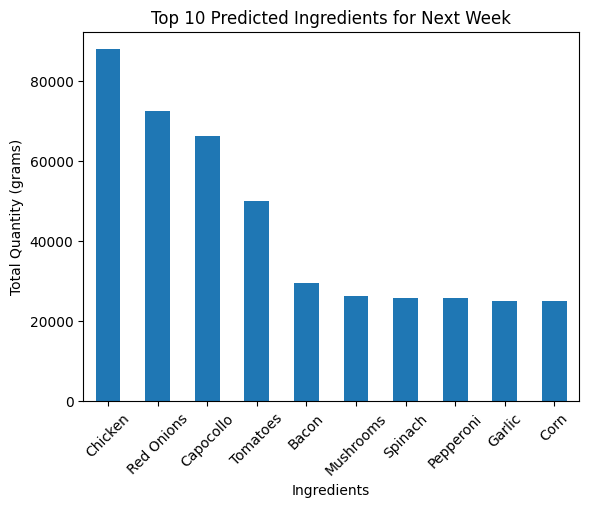

In [104]:
# Visualizing the total quantities of ingredients
ingredient_totals_df=pd.DataFrame(ingredient_totals.items(),columns=['Ingredients','Total Quantity (in grams)'])
ingredient_totals_df

plt.figure(figsize=(12, 8))
ingredient_totals_df.nlargest(10, 'Total Quantity (in grams)').plot(kind='bar', x='Ingredients', y='Total Quantity (in grams)', legend=False)
plt.title('Top 10 Predicted Ingredients for Next Week')
plt.ylabel('Total Quantity (grams)')
plt.xticks(rotation=45)
plt.show()

In [105]:
ingredient_totals_df.to_csv('/content/drive/MyDrive/Colab Notebooks/predicted_ingredient_totals.csv', index=False)

In [106]:
ingredients_predicted.to_csv('/content/drive/MyDrive/Colab Notebooks/Predicted Data.csv',index=False)